### Introduction 

Lately I have been indulged in learning all things tidymodels in my after office hours following along the [blog](https://juliasilge.com) of excellent Julia Silge and reading through [Tidy Machine Learning with R](https://www.tmwr.org) book by her and Max Kuhn of caret fame. But I was missing something - the effectiveness of my learning journey. Committing to large scale competition was unwieldy but then came #Sliced - a data science problem solving 2-hour sprint with small datasets.

Here, I am trying to tackle the S0102 problem with **Aircraft wildlife strikes** dataset.

### Load Libraries and other presets

In [1]:
library(tidyverse) # Data Wrangling
library(tidymodels) # Modelling
library(themis) # Class imbalance
library(plotly) # Interactive plots
library(parallel) # Parallel operations
library(doParallel) # Parallel operations
library(tictoc) # Timing

library(GGally) # For pair plots

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.4     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 0.1.3 ──

✔ broom        0.7.7      ✔ rsample      0.1.0 
✔ dials        0.0.9      ✔ tune         0.1.5 
✔ infer        0.5.4      ✔ workflows    0.2.2 
✔ modeldata    0.1.0      ✔ workflowsets 0.0.2 
✔ parsnip      0.1.5      ✔ yardstick    0.0.8 
✔ recipes      0.1.16     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spe

#### Enable parallel processing

In [2]:
cores<-detectCores(logical=F)-1
# cores

core_cluster<-makePSOCKcluster(cores)
# core_cluster

registerDoParallel(core_cluster)

### Get Train and test data
Here I did a few things other than reading data - 
* Converted all character columns to factors to play nice with different models
* Releveled factor so that our target outcome true label is "damaged". It will make it easier to read the results.

#### Train data

In [3]:
train_orig<-read_csv("../input/sliced-s01e02-xunyc5/train.csv",
                     guess_max=1e5)%>%
  mutate(
    damaged=case_when(
      damaged>0 ~ "damaged",
      TRUE ~ "no damage"
    ),
    across(where(is.character),as_factor),
    damaged=fct_relevel(damaged,"damaged")
  )


# Check out training data
train_orig%>%
  glimpse()


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_character(),
  id = col_double(),
  incident_year = col_double(),
  incident_month = col_double(),
  incident_day = col_double(),
  aircraft_model = col_double(),
  aircraft_mass = col_double(),
  engine_make = col_double(),
  engines = col_double(),
  engine1_position = col_double(),
  engine2_position = col_double(),
  engine4_position = col_double(),
  height = col_double(),
  speed = col_double(),
  distance = col_double(),
  damaged = col_double()
)
ℹ Use `spec()` for the full column specifications.




Rows: 21,000
Columns: 34
$ id               <dbl> 23637, 8075, 5623, 19605, 15142, 27235, 12726, 20781,…
$ incident_year    <dbl> 1996, 1999, 2011, 2007, 2007, 2013, 2002, 2013, 2015,…
$ incident_month   <dbl> 11, 6, 12, 9, 9, 5, 5, 5, 7, 8, 10, 9, 11, 7, 5, 3, 3…
$ incident_day     <dbl> 7, 26, 1, 13, 13, 28, 4, 19, 22, 22, 21, 7, 2, 7, 20,…
$ operator_id      <fct> MIL, UAL, SWA, SWA, MIL, UNK, UAL, BUS, UNK, BUS, EGF…
$ operator         <fct> MILITARY, UNITED AIRLINES, SOUTHWEST AIRLINES, SOUTHW…
$ aircraft         <fct> T-1A, B-757-200, B-737-300, B-737-700, KC-135R, UNKNO…
$ aircraft_type    <fct> A, A, A, A, A, NA, A, A, NA, A, A, A, A, NA, A, A, A,…
$ aircraft_make    <fct> 748, 148, 148, 148, NA, NA, 148, 226, NA, NA, 332, 58…
$ aircraft_model   <dbl> NA, 26, 24, 42, NA, NA, 97, 7, NA, NA, 14, 22, 37, NA…
$ aircraft_mass    <dbl> 3, 4, 4, 4, NA, NA, 4, 1, NA, 1, 3, 4, 4, NA, 4, 4, 4…
$ engine_make      <dbl> 31, 34, 10, 10, NA, NA, 34, 7, NA, NA, 1, 34, 34, NA,…
$ engine_model 

#### Test data

In [4]:
test<-read_csv("../input/sliced-s01e02-xunyc5/test.csv",
               guess_max = 1e5
               )%>%
  mutate(
    across(where(is.character),as_factor)
  )


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_character(),
  id = col_double(),
  incident_year = col_double(),
  incident_month = col_double(),
  incident_day = col_double(),
  aircraft_model = col_double(),
  aircraft_mass = col_double(),
  engine_make = col_double(),
  engines = col_double(),
  engine1_position = col_double(),
  engine2_position = col_double(),
  engine4_position = col_double(),
  height = col_double(),
  speed = col_double(),
  distance = col_double()
)
ℹ Use `spec()` for the full column specifications.




### Exploratory Data Analysis
Here I am not much focusing on EDA. But some charts will not hurt. Taken some queue from Julia Silge's post and added some of my own on top.

#### Class balance check
The outcome is severly imbalanced. We will address that in pre-processing step.

[1] 0.9143333

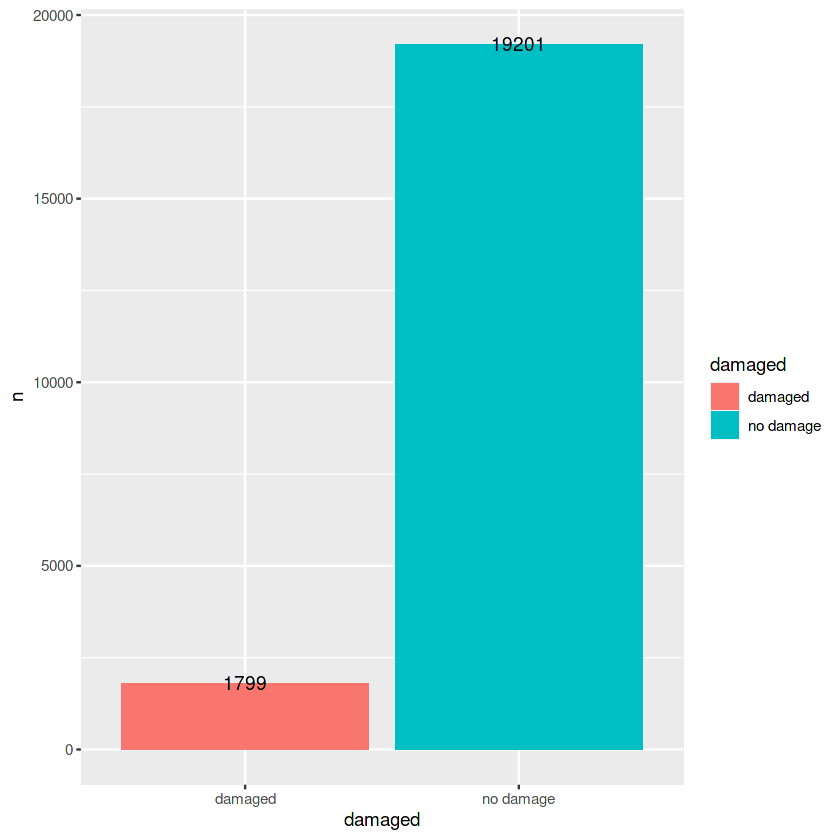

In [5]:
train_orig%>%
  count(damaged)%>%
  ggplot(aes(damaged,n,fill=damaged))+
  geom_col()+
  geom_text(aes(label=n))


balance_share<-train_orig%>%
  count(damaged)%>%
  mutate(
    share=n/sum(n)
  )%>%
  slice_max(share)%>%
  select(share)%>%
  pull()

balance_share # Will be using this on another viz

#### Checking Pair plots of numeric variables 
So many variables made the plot ugly. We see that some variables like *speed, height* . But for this model I will be skipping this pre-processing.

Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 5694 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 5696 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 5838 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 6776 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 20650 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 8469 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 12358 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm

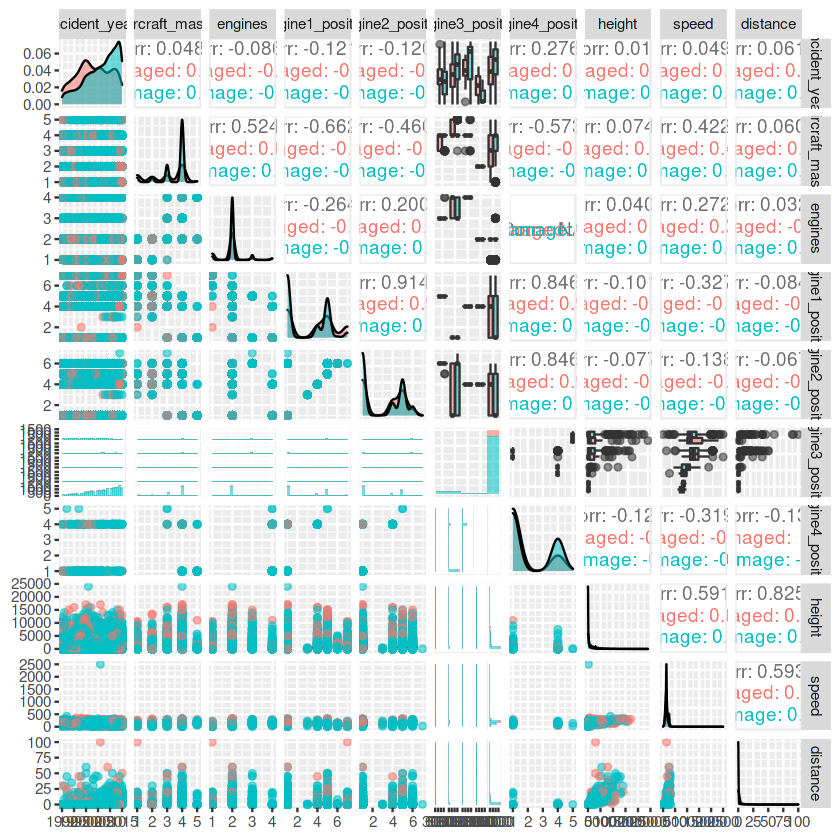

In [6]:
train_orig%>%
  select(damaged,incident_year,aircraft_mass,
         engines,contains("_position"),
         height,speed,distance
         )%>%
  ggpairs(columns = 2:11,
          aes(color=damaged,alpha=0.5),
          progress=FALSE
          )

#### Categorical variables exploration
So many categorical variables! Lets visualize those with less than 15 levels and see whether they are inline with the outcome imbalance.

In [7]:
categoric_summary<-train_orig%>%
  select(where(is_character),where(is.factor))%>%
  map_df(~tibble(
          distinct=n_distinct(.x)
      ),
      .id="variable"
    )%>%
  arrange(-distinct)

categoric_summary

variable,distinct
<chr>,<int>
airport_id,1039
airport,1039
species_id,447
species_name,446
aircraft,424
operator_id,276
operator,275
aircraft_make,63
state,61


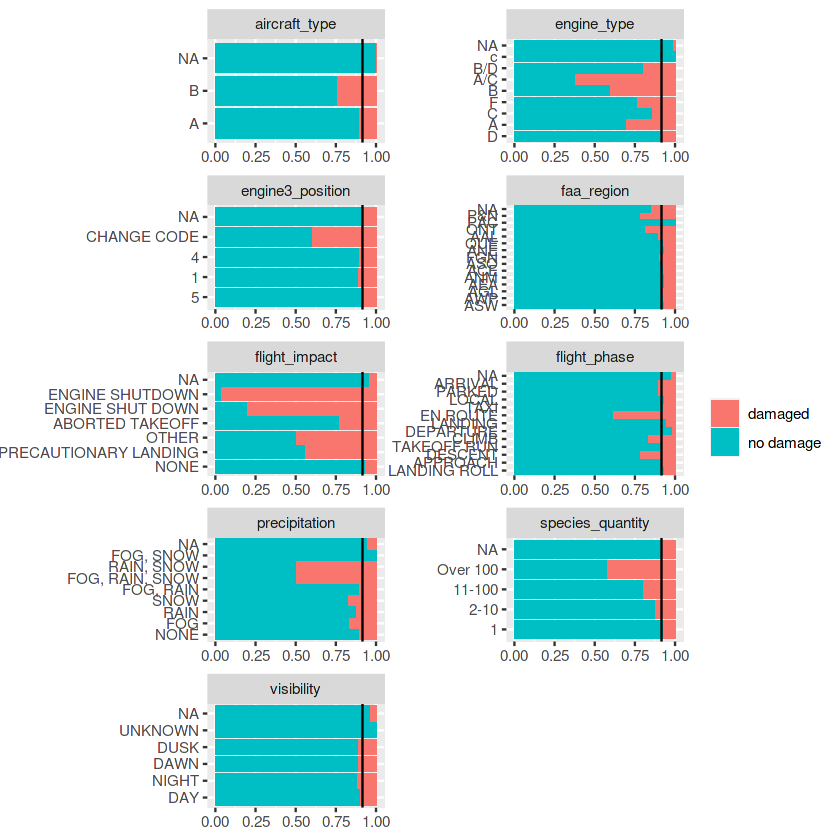

In [8]:
train_orig%>%
  select(damaged,categoric_summary%>%
           filter(distinct<=15)%>%
           select(variable)%>%
           pull()
           )%>%
  pivot_longer(2:last_col())%>%
  ggplot(aes(y=value,fill=damaged))+
  geom_bar(position="fill")+
  geom_vline(xintercept = balance_share)+
  facet_wrap(vars(name),scales="free",ncol=2)+
  labs(
    x=NULL,y=NULL,fill=NULL
  )

Closer inspection indeed indicates that some levels may provide better predictive capability. Dummy variables encoding may work wonders.

### Limited variables dataframe
Instead of lots of variables, I choose to use some select variables (taking cues from other bloggers and adding some of mine) for my model.

In [9]:
train_df<-train_orig%>%
    select(
    damaged, flight_impact, precipitation,
    visibility, flight_phase, engines, incident_year,
    species_id, engine_type,aircraft_model, 
    species_quantity, height, speed, distance
  )


train_df%>%
  glimpse()

Rows: 21,000
Columns: 14
$ damaged          <fct> no damage, damaged, no damage, no damage, no damage, …
$ flight_impact    <fct> NA, NA, NONE, NONE, NA, NA, NA, NONE, NA, NA, NONE, N…
$ precipitation    <fct> NA, NA, "NONE", "NONE", NA, NA, NA, "FOG", NA, NA, "N…
$ visibility       <fct> DAY, NA, DAY, NIGHT, NIGHT, NA, NA, NIGHT, NA, NIGHT,…
$ flight_phase     <fct> LANDING ROLL, NA, LANDING ROLL, APPROACH, APPROACH, N…
$ engines          <dbl> 2, 2, 2, 2, NA, NA, 2, 1, NA, 2, 2, 2, 2, NA, 2, 2, 2…
$ incident_year    <dbl> 1996, 1999, 2011, 2007, 2007, 2013, 2002, 2013, 2015,…
$ species_id       <fct> UNKBM, UNKBM, ZT002, UNKBS, ZT105, YI005, UNKBM, UNKB…
$ engine_type      <fct> D, D, D, D, NA, NA, D, A, NA, C, D, D, D, NA, D, D, D…
$ aircraft_model   <dbl> NA, 26, 24, 42, NA, NA, 97, 7, NA, NA, 14, 22, 37, NA…
$ species_quantity <fct> 1, 1, 1, 1, NA, 1, 1, 1, 1, 1, 1, 2-10, 1, 1, 2-10, 1…
$ height           <dbl> 0, NA, 0, 300, NA, NA, NA, 2700, NA, 0, 3500, 1400, 0…
$ speed        

### Partitioning
Here I split the original training data into train and validation set. 
Then resample the train set with 10-fold stratified cross validation.
Will use the validation set for another layer of checking of the model.

In [10]:
set.seed(123)

splits<-initial_split(train_df,strata = damaged)


train<-training(splits)
valid<-testing(splits)

folds<-vfold_cv(train,v = 10,strata = damaged)

### Recipe to preprocess
Here the strategy is -
* Handle factors with many levels by lumping them together
* Removing highly correlated numeric variables
* Dummy encoding
* Imputation, zero variance feature removal
* Wanted to upsample. But results were poor. So, keeping that option out

In [11]:
rec_base<-train%>%
  recipe(damaged~.)%>%
  step_corr(all_numeric_predictors())%>%
  step_novel(all_nominal_predictors())%>%
  step_other(all_nominal_predictors(),threshold=0.01)%>%
  step_unknown(all_nominal_predictors())%>%
  step_dummy(all_nominal_predictors())%>%
  step_impute_median(all_numeric_predictors())%>%
  step_zv(all_predictors())

rec_base

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         13

Operations:

Correlation filter on all_numeric_predictors()
Novel factor level assignment for all_nominal_predictors()
Collapsing factor levels for all_nominal_predictors()
Unknown factor level assignment for all_nominal_predictors()
Dummy variables from all_nominal_predictors()
Median Imputation for all_numeric_predictors()
Zero variance filter on all_predictors()

### Model to use - GLMNet
We set two tunable parameters in GLMNet model.

In [12]:
logistic_reg_glmnet_spec <-
  logistic_reg(penalty = tune(), mixture = tune()) %>%
  set_engine('glmnet')

### Create Workflow

In [13]:
LR_glmnet_wf<-workflow()%>%
  add_recipe(rec_base)%>%
  add_model(logistic_reg_glmnet_spec)

LR_glmnet_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: logistic_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
7 Recipe Steps

• step_corr()
• step_novel()
• step_other()
• step_unknown()
• step_dummy()
• step_impute_median()
• step_zv()

── Model ───────────────────────────────────────────────────────────────────────
Logistic Regression Model Specification (classification)

Main Arguments:
  penalty = tune()
  mixture = tune()

Computational engine: glmnet 


### Tune grid for hyperparameter tuning 
We vary with 20 different combination of penalty and mixture.

In [14]:
LR_glmnet_grid<-grid_max_entropy(
  parameters(LR_glmnet_wf),
  size=20
)

LR_glmnet_grid%>%
    head()

penalty,mixture
<dbl>,<dbl>
2.500981e-10,0.08830836
5.953631e-07,0.66895094
2.202713e-06,0.45129516
3.758730e-09,0.97296656
7.915615e-05,0.08640609
2.277882e-04,0.77672226


### Tuning 

In [15]:
tic()

metrics_interest<-metric_set(mn_log_loss)

set.seed(123)

LR_glmnet_tune<-LR_glmnet_wf%>%
  tune_grid(
    resamples=folds,
    grid=LR_glmnet_grid,
    metrics=metrics_interest,
    control=control_grid(parallel_over =NULL)
  )

toc()

165.74 sec elapsed


In [16]:
LR_glmnet_tune%>%
    collect_metrics()%>%
    slice_min(mean,n=5)

penalty,mixture,.metric,.estimator,mean,n,std_err,.config
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
4.585642e-04,0.9784341,mn_log_loss,binary,0.2161570,10,0.004765235,Preprocessor1_Model20
8.377118e-04,0.4038325,mn_log_loss,binary,0.2161637,10,0.004763827,Preprocessor1_Model07
2.277882e-04,0.7767223,mn_log_loss,binary,0.2163503,10,0.004778623,Preprocessor1_Model15
1.093529e-10,0.2268576,mn_log_loss,binary,0.2164345,10,0.004785378,Preprocessor1_Model06
8.992394e-07,0.2134308,mn_log_loss,binary,0.2164358,10,0.004784298,Preprocessor1_Model05


### Get the best parameters and fit on full training set

In [17]:
best_params<-LR_glmnet_tune%>%select_best()
best_params

penalty,mixture,.config
<dbl>,<dbl>,<chr>
0.0004585642,0.9784341,Preprocessor1_Model20


In [18]:
final_wf_fit<-LR_glmnet_wf%>%
        finalize_workflow(best_params)%>%
        fit(data=train)


### Predict on validation sets

In [19]:
valid_preds<-final_wf_fit%>%
    augment(valid)

In [20]:
valid_preds%>%
    metrics_interest(truth=damaged,estimate=.pred_class,.pred_damaged)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
mn_log_loss,binary,0.2207629


Validation metrics are pretty close to our resampling metrics. So, we may not be overfitting.

### Predict on test set and submission file

In [21]:
test_preds<-final_wf_fit%>%
    augment(test)%>%
    select(id,damaged=.pred_damaged)

test_preds%>%head()

Warning message:
“Novel levels found in column 'species_id': 'ZX321', 'L4303', 'YJ001', '1D1', 'K3301', 'ZX013', 'NE302', 'Z5101', 'N6035', 'Y9003', 'T3006', '2D4', 'G3001', 'ZX029', 'Q2104', 'N6009', '1F53', 'J2145', 'O2214', 'ZX316', 'ZX025', '1F33', '1C2110', 'ZT2', 'Z1001', 'F1004', 'L3105', '2A9', 'NE213', 'ZV003', 'ZT106', 'YR401', 'N6034', 'L5002', 'Z6006', 'N6104', 'L4302', 'N8203', '1G71', 'ZX007', 'T1001', 'S5211', 'ZX404'. The levels have been removed, and values have been coerced to 'NA'.”
Warning message:
“Novel levels found in column 'engine_type': 'X'. The levels have been removed, and values have been coerced to 'NA'.”


id,damaged
<dbl>,<dbl>
11254,0.090200067
27716,0.014933938
29066,0.021837036
3373,0.072401319
1996,0.068423728
18061,0.004659758


In [22]:
test_preds%>%
    write_csv("submission_glmnet.csv")

In [23]:
stopCluster(core_cluster)